##**Flight Delay Prediction and Analysis**

###1.Environment

In [1]:
!pip install pyspark

In [2]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://bitbucket.org/habedi/datasets/raw/b6769c4664e7ff68b001e2f43bc517888cbe3642/spark/spark-3.0.2-bin-hadoop2.7.tgz
!tar xf spark-3.0.2-bin-hadoop2.7.tgz
!rm -rf spark-3.0.2-bin-hadoop2.7.tgz*
!pip -q install findspark pyspark graphframes

In [3]:
!pip install kaggle

In [4]:
#Kaggle API
import os
os.environ['KAGGLE_USERNAME'] = "joycegaohaun"
os.environ['KAGGLE_KEY'] = "5cf5930b3c30b1a3be163b0837ca4916"

In [5]:
#Initializing the environment
import os
os.environ["PYSPARK_DRIVER_PYTHON"] = "jupyter"
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"] = "notebook"
os.environ["PYSPARK_SUBMIT_ARGS"] = "--packages graphframes:graphframes:0.8.1-spark3.0-s_2.12 pyspark-shell"

In [6]:
from graphframes import *
from pyspark.sql.functions import *

###2.Load Data

In [7]:
import kaggle
!kaggle datasets download -d usdot/flight-delays

flight-delays.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
!ls -l --block-size=MB

total 793MB
-rw-r--r--  1 root root   1MB Mar 11 01:46 airlines.csv
-rw-r--r--  1 root root   1MB Mar 11 01:46 airports.csv
-rw-r--r--  1 root root 201MB Sep 20  2019 flight-delays.zip
-rw-r--r--  1 root root 593MB Mar 11 01:46 flights.csv
drwxr-xr-x  1 root root   1MB Mar  7 14:32 sample_data
drwxr-xr-x 13 1000 1000   1MB Feb 16  2021 spark-3.0.2-bin-hadoop2.7


In [9]:
from zipfile import ZipFile
with ZipFile('flight-delays.zip','r') as zip:
     zip.printdir()
     zip.extractall()

File Name                                             Modified             Size
airlines.csv                                   2019-09-20 08:07:02          359
airports.csv                                   2019-09-20 08:07:02        23867
flights.csv                                    2019-09-20 08:07:10    592406591


In [10]:
from pyspark.sql import SparkSession
session=SparkSession.builder.appName("flight").master("local").getOrCreate()

###3.Data Cleaning

In [11]:
data=session.read.csv('/content/flights.csv', header=True, inferSchema=True)

In [12]:
print("Number of observations:",data.count())
print("Information of columns:\n",data.columns)
print("First few records:\n", data.show())

Number of observations: 5819079
Information of columns:
 ['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']
+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NU

In [13]:
data=data.drop('SCHEDULED_ARRIVAL','ARRIVAL_TIME','WHEELS_OFF','WHEELS_ON','SCHEDULED_DEPARTURE','DEPARTURE_TIME', 'DIVERTED','CANCELLED','CANCELLATION_REASON','AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY')

In [14]:
data=data.na.drop(subset='ARRIVAL_DELAY')

In [15]:
def miss_fuc(record):
  for column in record.columns:
    new_record=record.filter(record[column].isNull())
    number=new_record.count()
    print(column, number)

In [16]:
miss_fuc(data)

YEAR 0
MONTH 0
DAY 0
DAY_OF_WEEK 0
AIRLINE 0
FLIGHT_NUMBER 0
TAIL_NUMBER 0
ORIGIN_AIRPORT 0
DESTINATION_AIRPORT 0
DEPARTURE_DELAY 0
TAXI_OUT 0
SCHEDULED_TIME 0
ELAPSED_TIME 0
AIR_TIME 0
DISTANCE 0
TAXI_IN 0
ARRIVAL_DELAY 0


In [17]:
data.describe(['ARRIVAL_DELAY']).show()

+-------+-----------------+
|summary|    ARRIVAL_DELAY|
+-------+-----------------+
|  count|          5714008|
|   mean|4.407057357987598|
| stddev|39.27129709388608|
|    min|              -87|
|    max|             1971|
+-------+-----------------+



In [18]:
from pyspark.sql.functions import when
data=data.withColumn('DELAY', when(data.ARRIVAL_DELAY > 15, 1).otherwise(0))

In [19]:
data.show(2, truncate=False)

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+---------------+--------+--------------+------------+--------+--------+-------+-------------+-----+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|DEPARTURE_DELAY|TAXI_OUT|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|TAXI_IN|ARRIVAL_DELAY|DELAY|
+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+---------------+--------+--------------+------------+--------+--------+-------+-------------+-----+
|2015|1    |1  |4          |AS     |98           |N407AS     |ANC           |SEA                |-11            |21      |205           |194         |169     |1448    |4      |-22          |0    |
|2015|1    |1  |4          |AA     |2336         |N3KUAA     |LAX           |PBI                |-8             |12      |280           |279         |263     |2330    |4      |-9           |0    |
+----+-----+---

###4.Machine Learning

In [37]:
from pyspark.ml.feature import StringIndexer
str_idx=StringIndexer(inputCols=['AIRLINE','TAIL_NUMBER','ORIGIN_AIRPORT','DESTINATION_AIRPORT'], outputCols=['AIRLINE1','TAIL_NUMBER1','ORIGIN_AIRPORT1','DESTINATION_AIRPORT1']).setHandleInvalid("keep")

In [38]:
from pyspark.ml.feature import OneHotEncoder
onehot=OneHotEncoder(inputCols=['AIRLINE1','TAIL_NUMBER1','ORIGIN_AIRPORT1','DESTINATION_AIRPORT1'], outputCols=['AIRLINE2','TAIL_NUMBER2','ORIGIN_AIRPORT2','DESTINATION_AIRPORT2'])

In [39]:
from pyspark.ml.feature import VectorAssembler
assembler=VectorAssembler(inputCols=['YEAR','MONTH','DAY','DAY_OF_WEEK','AIRLINE2','TAIL_NUMBER2','ORIGIN_AIRPORT2','DESTINATION_AIRPORT2','TAXI_OUT','SCHEDULED_TIME','ELAPSED_TIME','AIR_TIME','DISTANCE','TAXI_IN'], outputCol='all_features')

In [40]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
rdforest=RandomForestClassifier(featuresCol='all_features', labelCol="DELAY")
rdforestpipeline=Pipeline(stages=[str_idx,onehot,assembler,rdforest])
training, test=data.randomSplit([0.75,0.25], seed=1000)
rdforestmodel=rdforestpipeline.fit(training)
rdforestresults=rdforestmodel.transform(test)
rdforestresults.show(2, truncate=False)

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+---------------+--------+--------------+------------+--------+--------+-------+-------------+-----+--------+------------+---------------+--------------------+--------------+-------------------+----------------+--------------------+---------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------+----------------------------------------+----------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|DEPARTURE_DELAY|TAXI_OUT|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|TAXI_IN|ARRIVAL_DELAY|DELAY|AIRLINE1|TAIL_NUMBER1|ORIGIN_AIRPORT1|DESTINATION_AIRPORT1|AIRLINE2      |TAIL_NUMBER2       |ORIGIN_AIRPORT2 |DESTINATION_AIRPORT2|all_features                                                                                                       

In [41]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
rd_eval = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="DELAY",metricName="accuracy")
print(rd_eval.evaluate(rdforestresults))

0.8211343261024866


In [44]:
# Creating a logistic regression model
from pyspark.ml.classification import LogisticRegression
lm = LogisticRegression(featuresCol='all_features', labelCol="DELAY")
# Creating the pipeline
lm_pipeline = Pipeline(stages=[str_idx,onehot,assembler,lm])
# Training the Model
lm_train = lm_pipeline.fit(training)
# Predicting the model
lm_pred = lm_train.transform(test)
lm_pred.show(2, truncate=False)

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+---------------+--------+--------------+------------+--------+--------+-------+-------------+-----+--------+------------+---------------+--------------------+--------------+-------------------+----------------+--------------------+---------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------+----------------------------------------+----------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|DEPARTURE_DELAY|TAXI_OUT|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|TAXI_IN|ARRIVAL_DELAY|DELAY|AIRLINE1|TAIL_NUMBER1|ORIGIN_AIRPORT1|DESTINATION_AIRPORT1|AIRLINE2      |TAIL_NUMBER2       |ORIGIN_AIRPORT2 |DESTINATION_AIRPORT2|all_features                                                                                                      

In [45]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
lm_eval = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="DELAY",metricName="accuracy")
print(lm_eval.evaluate(lm_pred))

0.849773404860478


In [46]:
from pyspark.ml.classification import DecisionTreeClassifier
# Creating tree model
tree = DecisionTreeClassifier(featuresCol='all_features', labelCol="DELAY")
treepipeline = Pipeline(stages=[str_idx,onehot,assembler,tree])
# Training the model
treemodel = treepipeline.fit(training)
tree_pred = treemodel.transform(test)
tree_pred.show(2, truncate=False)

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+---------------+--------+--------------+------------+--------+--------+-------+-------------+-----+--------+------------+---------------+--------------------+--------------+-------------------+----------------+--------------------+---------------------------------------------------------------------------------------------------------------------------------------+--------------------+----------------------------------------+----------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|DEPARTURE_DELAY|TAXI_OUT|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|TAXI_IN|ARRIVAL_DELAY|DELAY|AIRLINE1|TAIL_NUMBER1|ORIGIN_AIRPORT1|DESTINATION_AIRPORT1|AIRLINE2      |TAIL_NUMBER2       |ORIGIN_AIRPORT2 |DESTINATION_AIRPORT2|all_features                                                                                                                          

In [47]:
tree_eval = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="DELAY",metricName="accuracy")
tree_eval.evaluate(tree_pred)

0.8356844138788037

###5.Graph Analysis

In [48]:
airports=session.read.csv('/content/airports.csv',header=True,inferSchema=True)
airports.show(2, truncate=False)
airports.createOrReplaceTempView('airports')

+---------+-----------------------------------+---------+-----+-------+--------+---------+
|IATA_CODE|AIRPORT                            |CITY     |STATE|COUNTRY|LATITUDE|LONGITUDE|
+---------+-----------------------------------+---------+-----+-------+--------+---------+
|ABE      |Lehigh Valley International Airport|Allentown|PA   |USA    |40.65236|-75.4404 |
|ABI      |Abilene Regional Airport           |Abilene  |TX   |USA    |32.41132|-99.6819 |
+---------+-----------------------------------+---------+-----+-------+--------+---------+
only showing top 2 rows



In [49]:
flights=data
flights.show(2, truncate=False)
flights.createOrReplaceTempView("flights")
flights.cache()

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+---------------+--------+--------------+------------+--------+--------+-------+-------------+-----+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|DEPARTURE_DELAY|TAXI_OUT|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|TAXI_IN|ARRIVAL_DELAY|DELAY|
+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+---------------+--------+--------------+------------+--------+--------+-------+-------------+-----+
|2015|1    |1  |4          |AS     |98           |N407AS     |ANC           |SEA                |-11            |21      |205           |194         |169     |1448    |4      |-22          |0    |
|2015|1    |1  |4          |AA     |2336         |N3KUAA     |LAX           |PBI                |-8             |12      |280           |279         |263     |2330    |4      |-9           |0    |
+----+-----+---

DataFrame[YEAR: int, MONTH: int, DAY: int, DAY_OF_WEEK: int, AIRLINE: string, FLIGHT_NUMBER: int, TAIL_NUMBER: string, ORIGIN_AIRPORT: string, DESTINATION_AIRPORT: string, DEPARTURE_DELAY: int, TAXI_OUT: int, SCHEDULED_TIME: int, ELAPSED_TIME: int, AIR_TIME: int, DISTANCE: int, TAXI_IN: int, ARRIVAL_DELAY: int, DELAY: int]

In [50]:
distinctcode=session.sql("select distinct iata from (select distinct ORIGIN_AIRPORT as iata from flights union all select distinct DESTINATION_AIRPORT as iata from flights) a")
distinctcode.show(2, truncate=False)
distinctcode.createOrReplaceTempView("distinctcode")
distinctcode.cache()

+----+
|iata|
+----+
|BGM |
|PSE |
+----+
only showing top 2 rows



DataFrame[iata: string]

In [51]:
airports=session.sql("select a.IATA_CODE,a.AIRPORT,a.CITY,a.STATE,a.COUNTRY,a.LATITUDE,a.LONGITUDE from airports a join distinctcode c on a.IATA_CODE=c.iata")
airports.show(2, truncate=False)
airports.createOrReplaceTempView("airports")
airports.cache()

+---------+-----------------------------------+---------+-----+-------+--------+---------+
|IATA_CODE|AIRPORT                            |CITY     |STATE|COUNTRY|LATITUDE|LONGITUDE|
+---------+-----------------------------------+---------+-----+-------+--------+---------+
|ABE      |Lehigh Valley International Airport|Allentown|PA   |USA    |40.65236|-75.4404 |
|ABI      |Abilene Regional Airport           |Abilene  |TX   |USA    |32.41132|-99.6819 |
+---------+-----------------------------------+---------+-----+-------+--------+---------+
only showing top 2 rows



DataFrame[IATA_CODE: string, AIRPORT: string, CITY: string, STATE: string, COUNTRY: string, LATITUDE: double, LONGITUDE: double]

In [52]:
flightsData=session.sql("""
    SELECT
        f.ORIGIN_AIRPORT AS src,
        f.DESTINATION_AIRPORT AS dst,
        CAST(f.ARRIVAL_DELAY AS INT),
        CAST(f.DISTANCE AS INT)
    FROM
        flights f
""")
flightsData.show(5, truncate=False)
flightsData.createOrReplaceTempView("flightsData")
flightsData.cache()

+---+---+-------------+--------+
|src|dst|ARRIVAL_DELAY|DISTANCE|
+---+---+-------------+--------+
|ANC|SEA|-22          |1448    |
|LAX|PBI|-9           |2330    |
|SFO|CLT|5            |2296    |
|LAX|MIA|-9           |2342    |
|SEA|ANC|-21          |1448    |
+---+---+-------------+--------+
only showing top 5 rows



DataFrame[src: string, dst: string, ARRIVAL_DELAY: int, DISTANCE: int]

In [53]:
Vertices=airports.withColumnRenamed("IATA_CODE","id").distinct()
Edges=flightsData.select("src","dst","ARRIVAL_DELAY")
Vertices.cache()
Edges.cache()

DataFrame[src: string, dst: string, ARRIVAL_DELAY: int]

In [54]:
flightGraph =GraphFrame(Vertices, Edges)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


In [55]:
Vertices.show()
Edges.show()

+---+--------------------+------------+-----+-------+--------+----------+
| id|             AIRPORT|        CITY|STATE|COUNTRY|LATITUDE| LONGITUDE|
+---+--------------------+------------+-----+-------+--------+----------+
|PIH|Pocatello Regiona...|   Pocatello|   ID|    USA|42.91131|-112.59586|
|VEL|      Valdez Airport|      Vernal|   UT|    USA| 40.4409|-109.50992|
|MYR|Myrtle Beach Inte...|Myrtle Beach|   SC|    USA|33.67975| -78.92833|
|CAK|Akron-Canton Regi...|       Akron|   OH|    USA|40.91631| -81.44247|
|DBQ|Dubuque Regional ...|     Dubuque|   IA|    USA|42.40296| -90.70917|
|YUM|Yuma Internationa...|        Yuma|   AZ|    USA|32.65658|-114.60597|
|CRW|      Yeager Airport|  Charleston|   WV|    USA|38.37315| -81.59319|
|LNK|Lincoln Airport (...|     Lincoln|   NE|    USA|40.85097| -96.75925|
|MAF|Midland Internati...|     Midland|   TX|    USA|31.94253|-102.20191|
|PSP|Palm Springs Inte...|Palm Springs|   CA|    USA|33.82922|-116.50625|
|MOB|Mobile Regional A...|      Mobile

In [56]:
flightGraph.edges\
  .filter("src='BWI' and ARRIVAL_DELAY>15")\
  .groupby("src","dst")\
  .avg("ARRIVAL_DELAY")\
  .sort(desc("avg(ARRIVAL_DELAY)"))\
  .show(10)

+---+---+------------------+
|src|dst|avg(ARRIVAL_DELAY)|
+---+---+------------------+
|BWI|SFO|              79.2|
|BWI|MSP| 78.94339622641509|
|BWI|DFW| 78.42521994134897|
|BWI|ORD| 74.92746113989638|
|BWI|ATL| 71.05668016194332|
|BWI|IAH| 70.77533039647577|
|BWI|MYR| 69.15555555555555|
|BWI|ECP|  69.0576923076923|
|BWI|MEM| 68.28571428571429|
|BWI|DTW| 67.08354430379747|
+---+---+------------------+
only showing top 10 rows



In [57]:
top_airports=flightGraph.degrees.orderBy(['Degree'], ascending = [False])
top_airports=top_airports.limit(5)
top_airports.show()

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+---+------+
| id|degree|
+---+------+
|ATL|686582|
|ORD|552418|
|DFW|464411|
|DEN|386435|
|LAX|384139|
+---+------+



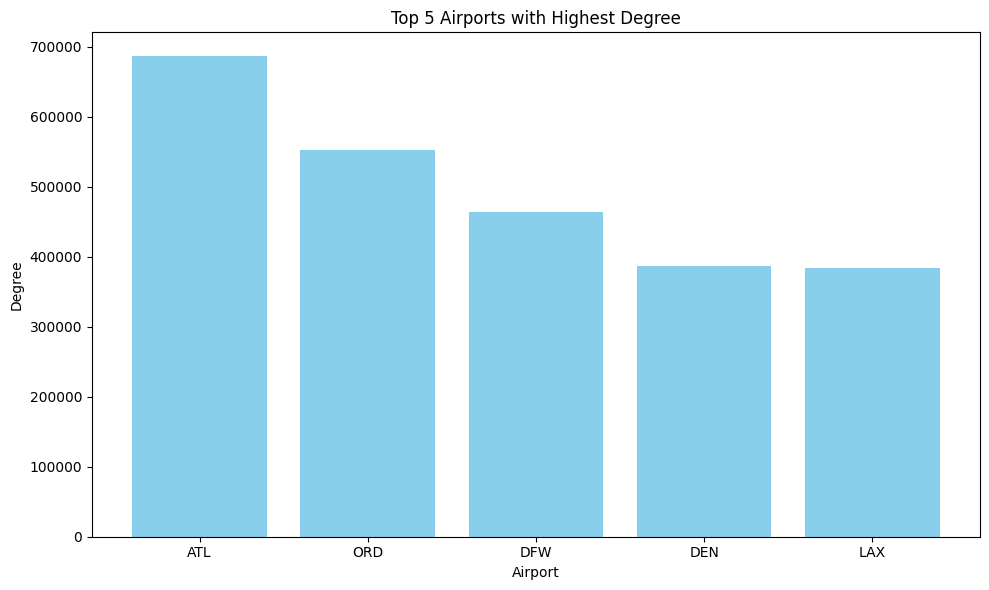

In [58]:
import matplotlib.pyplot as plt
airports = top_airports.select('id').rdd.flatMap(lambda x: x).collect()
degrees = top_airports.select('degree').rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(10, 6))
plt.bar(airports, degrees, color='skyblue')
plt.xlabel('Airport')
plt.ylabel('Degree')
plt.title('Top 5 Airports with Highest Degree')
plt.tight_layout()
plt.show()

In [59]:
from pyspark.sql.functions import rand
sampled_flightsData= flightsData.orderBy(rand()).limit(1000)
small_edges= sampled_flightsData.select("ARRIVAL_DELAY", "src", "dst")
small_edges.cache()

DataFrame[ARRIVAL_DELAY: int, src: string, dst: string]

In [60]:
smallflightGraph =GraphFrame(Vertices, small_edges)
ranks=smallflightGraph.pageRank(maxIter=5)
ranks.vertices.orderBy(ranks.vertices.pagerank.desc()).show()

+---+--------------------+-----------------+-----+-------+--------+----------+------------------+
| id|             AIRPORT|             CITY|STATE|COUNTRY|LATITUDE| LONGITUDE|          pagerank|
+---+--------------------+-----------------+-----+-------+--------+----------+------------------+
|ATL|Hartsfield-Jackso...|          Atlanta|   GA|    USA|33.64044| -84.42694|16.843156244843204|
|ORD|Chicago O'Hare In...|          Chicago|   IL|    USA| 41.9796| -87.90446|13.996537882830518|
|DFW|Dallas/Fort Worth...|Dallas-Fort Worth|   TX|    USA|32.89595|  -97.0372| 9.485810020678944|
|DEN|Denver Internatio...|           Denver|   CO|    USA|39.85841|  -104.667| 9.148010696806748|
|LAX|Los Angeles Inter...|      Los Angeles|   CA|    USA|33.94254|-118.40807| 7.598231835124515|
|MSP|Minneapolis-Saint...|      Minneapolis|   MN|    USA|44.88055| -93.21692|6.3859754776796995|
|SFO|San Francisco Int...|    San Francisco|   CA|    USA|  37.619|-122.37484| 6.316552561945452|
|PHX|Phoenix Sky Har

In [61]:
from pyspark.sql.functions import col, count, when

# Calculate total number of flights and count of delayed flights for each src airport
src_flight_counts = Edges.groupBy("src").agg(count("*").alias("total_flights"),count(when(col("ARRIVAL_DELAY") > 15, True)).alias("delay_count"))
src_flight_ratios = src_flight_counts.withColumn("delay_ratio", col("delay_count") / col("total_flights"))
src_flight_ratios.show()

+---+-------------+-----------+-------------------+
|src|total_flights|delay_count|        delay_ratio|
+---+-------------+-----------+-------------------+
|BGM|          259|         40|0.15444015444015444|
|PSE|          738|         98|0.13279132791327913|
|INL|          556|         67|0.12050359712230216|
|MSY|        38292|       6253|0.16329781677635016|
|PPG|          106|         31|0.29245283018867924|
|GEG|         9440|       1249| 0.1323093220338983|
|SNA|        36708|       5194|0.14149504195270785|
|BUR|        18527|       2592| 0.1399039240028067|
|GRB|         4720|        758|0.16059322033898304|
|GTF|         1944|        171|0.08796296296296297|
|IDA|         2225|        230|0.10337078651685393|
|GRR|        10541|       1627| 0.1543496821933403|
|JLN|          629|        132|0.20985691573926868|
|EUG|         3558|        549| 0.1543001686340641|
|PSG|          652|        131|  0.200920245398773|
|GSO|         6462|       1214|  0.187867533271433|
|PVD|       

In [62]:
filtered_ratio = src_flight_ratios.filter(src_flight_ratios["total_flights"] > 10000)
Vertices_with_ratio = Vertices.join(filtered_ratio, Vertices.id == filtered_ratio.src, "inner") \
    .select(Vertices["*"], filtered_ratio["delay_ratio"].alias("ratio"))
Vertices_with_ratio.show()

+---+--------------------+------------+-----+-------+--------+----------+-------------------+
| id|             AIRPORT|        CITY|STATE|COUNTRY|LATITUDE| LONGITUDE|              ratio|
+---+--------------------+------------+-----+-------+--------+----------+-------------------+
|MSY|Louis Armstrong N...| New Orleans|   LA|    USA|29.99339| -90.25803|0.16329781677635016|
|SNA|John Wayne Airpor...|   Santa Ana|   CA|    USA|33.67566|-117.86822|0.14149504195270785|
|BUR|Bob Hope Airport ...|     Burbank|   CA|    USA|34.20062| -118.3585| 0.1399039240028067|
|GRR|Gerald R. Ford In...|Grand Rapids|   MI|    USA|42.88082| -85.52277| 0.1543496821933403|
|PVD|Theodore Francis ...|  Providence|   RI|    USA|  41.724| -71.42822|0.15338849121502277|
|OAK|Oakland Internati...|     Oakland|   CA|    USA|37.72129|-122.22072|0.19662098922460342|
|DCA|Ronald Reagan Was...|   Arlington|   VA|    USA|38.85208| -77.03772|0.17626678215677782|
|CMH|Port Columbus Int...|    Columbus|   OH|    USA|39.9979

In [63]:
from pyspark.sql.functions import expr
import folium
# Calculate quartiles of the delay ratio
quartiles = Vertices_with_ratio.approxQuantile("ratio", [0.25, 0.75], 0.01)
q1, q3 = quartiles
Vertices_with_high_ratio = Vertices_with_ratio.withColumn("high_ratio", expr("CASE WHEN ratio >= {} THEN 1 ELSE 0 END".format(q3)))

# Create a map
m = folium.Map(location=[37.0902, -95.7129], zoom_start=5)
for row in Vertices_with_high_ratio.collect():
    if row.LATITUDE is not None and row.LONGITUDE is not None:
        color = 'red' if row.high_ratio == 1 else 'blue'
        folium.CircleMarker(
            location=[row.LATITUDE, row.LONGITUDE],
            radius=row.ratio * 50,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.5,
            popup=f"<b>Airport:</b> {row.AIRPORT}<br><b>City:</b> {row.CITY}<br><b>State:</b> {row.STATE}<br><b>Country:</b> {row.COUNTRY}<br><b>Delay Ratio:</b> {row.ratio}"
        ).add_to(m)

# Display the map
m